#338 Cups of Coffee

In [673]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from datetime import timedelta
import matplotlib.pyplot as plt
%matplotlib inline

## First, the ugly stuff
This data requires some preprocessing before we can do anything useful with it. Here I:
* Read the CSV into a Pandas DataFrame
* Print the columns to see what we have
* Select only the columns that have meaning
* Give the columns names that will be nicer to work with

In [674]:
coffee = pd.read_csv('20161216coffee.csv')
print coffee.columns

Index([u'CoffeeId', u'Person', u'Date', u'Date2', u'Time', u'Time2',
       u'datetime', u'Day of Week', u'Plain', u'Iced', u'Hot Espresso',
       u'Cold Espresso', u'Wakeup_time', u'Sleep_time',
       u'Stressed (binary yes or no)', u'Work/first class start time?',
       u'First, second, n_th coffee of the day? ',
       u'Pre-coffee mood (0 to 10, 5 is average)',
       u'post or current-coffee mood (0 to 10, 5 is average)', u'Hours sleep',
       u'Hours sleep 2', u'Units of Caffeine', u'Cumulative daily caffeine',
       u'Coffee', u'WeekNum', u'Comments?'],
      dtype='object')


In [675]:
cols = ['CoffeeId', 'Date', 'Time', 'datetime', 'Day of Week', 'Plain', 'Iced', 'Hot Espresso', \
       'Cold Espresso', 'Wakeup_time', 'Stressed (binary yes or no)', 'Work/first class start time?',\
       'First, second, n_th coffee of the day? ', 'Pre-coffee mood (0 to 10, 5 is average)', 'post or current-coffee mood (0 to 10, 5 is average)',\
       'Hours sleep', 'Units of Caffeine', 'Cumulative daily caffeine', 'Coffee', 'WeekNum']
coffee = coffee[cols]
coffee.columns = ['ID','Date','Time','Datetime','DOW','Plain','Iced', 'Hot_espresso','Cold_espresso','Wake_time',\
                  'Stressed','Work_time', 'Num_today_so_far', 'Pre_mood','Post_mood','Hours_sleep', \
                  'Units_caffeine', 'Cumulative_caff_day','Coffee','Week']

## Reformatting date and time features
Date and time features from Google Sheets are by default read in as strings. we need to change this to be able to calculate time differences, view trends over time, and have these sort nicely. Here, I:
* Reformat Date, Time, and Work/Class time into proper Date and Time types
* Create a Datetime column for viewing this as a time series
* Turn Hours Sleep into a timedelta type in order to get my bedtime from this feature and my wakeup time
* Get day of week and month of year, and week of year from the datetime value, allowing aggregation at different levels of precision

Note: Work_time has NaT in days where I had no work / class. This may need to be filtered later.

In [676]:
#Datetime
coffee['Datetime'] = coffee['Date'] + ' ' +  coffee['Time']
coffee['Datetime'] = pd.to_datetime(coffee['Datetime'], format='%m/%d/%Y %I:%M:%S %p')
coffee['Date'] = pd.to_datetime(coffee['Date'], format='%m/%d/%Y')

In [677]:
#more granular date / time features
coffee['Year'] = 2016
coffee['Month'] = coffee['Datetime'].dt.month
coffee['Day'] = coffee['Datetime'].dt.day
coffee['Hour'] = coffee['Datetime'].dt.hour
coffee['Minute'] = coffee['Datetime'].dt.minute

In [678]:
#work / class time and wakeup time to datetime.
coffee['Wake_time'] = coffee['Year'].astype(str) + "-" + coffee['Month'].astype(str) + "-" \
                    + coffee['Day'].astype(str) + " " + coffee['Wake_time']
coffee['Wake_time'] = pd.to_datetime(coffee['Wake_time'], format='%Y-%m-%d %I:%M %p')

coffee['Work_time'] = coffee['Year'].astype(str) + "-" + coffee['Month'].astype(str) + "-" \
                    + coffee['Day'].astype(str) + " " + coffee['Work_time']
coffee['Work_time'] = pd.to_datetime(coffee['Work_time'], format='%Y-%m-%d %I:%M %p')

In [679]:
#Hours sleep to timedelta. Get sleep time from hours sleep and wakeup time
coffee['Hours_sleep'] = pd.to_timedelta(coffee['Hours_sleep'], unit='h')
coffee['Bed_time'] = coffee['Wake_time'] - coffee['Hours_sleep']
coffee['Mood_change'] = coffee['Post_mood'] - coffee['Pre_mood']

** A look at the cleaned data: **

In [680]:
print coffee.head()

   ID       Date        Time            Datetime        DOW  Plain  Iced  \
0   1 2016-07-13  8:30:00 AM 2016-07-13 08:30:00  Wednesday      1     0   
1   2 2016-07-13  9:30:00 AM 2016-07-13 09:30:00  Wednesday      1     0   
2   3 2016-07-13  1:20:00 PM 2016-07-13 13:20:00  Wednesday      0     1   
3   4 2016-07-13  2:00:00 PM 2016-07-13 14:00:00  Wednesday      0     0   
4   5 2016-07-14  8:00:00 AM 2016-07-14 08:00:00   Thursday      1     0   

   Hot_espresso  Cold_espresso           Wake_time     ...       \
0             0              0 2016-07-13 06:00:00     ...        
1             0              0 2016-07-13 06:00:00     ...        
2             0              0 2016-07-13 06:00:00     ...        
3             1              0 2016-07-13 06:00:00     ...        
4             0              0 2016-07-14 06:20:00     ...        

   Cumulative_caff_day Coffee  Week  Year  Month  Day  Hour  Minute  \
0                    4      1    29  2016      7   13     8      30  

## Summary stats
Let's take a look at this from a birdseye view. In addition to the traditional set of summary statistics, it would be interesting to see: 
* How long I take, on average, from waking up to drinking my first cup
* A correlation matrix between the features, to see which ones might be related

___Summary Table___

A few interesting things appear in the summary stats. First, it is clear that I drink far more plain and iced coffee than I do espresso beverages, with the means of my non-espresso beverages showing that approximately 84% of my consumption is non-espresso. Next, my average post-coffee mood is 0.3 points higher than my average pre-coffee mood. This is not statistically significant, but it does reflect a pattern in the direction that one would expect from a regular consumer. Some of these stats should be taken with caution. Hours Sleep, for example, is not on a per-day basis, but rather on a per-coffee basis. If I consume three coffees in a day, for example, the observation recorded with each cup of coffee will have its own Hours_Sleep value attached. To get my true average nightly sleep, we first need to collapse it to be one observation per day, which I will do below. 

In [681]:
print 'Summary stats from 7/13 to 12/16:' + '\n'
coffee[['Plain', 'Iced', 'Hot_espresso', 'Cold_espresso', 'Stressed', 'Pre_mood', 'Post_mood', \
                               'Mood_change', 'Hours_sleep', 'Units_caffeine']].describe()

Summary stats from 7/13 to 12/16:



,Plain,Iced,Hot_espresso,Cold_espresso,Stressed,Pre_mood,Post_mood,Mood_change,Hours_sleep,Units_caffeine
count,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338,338.000000
mean,0.488166,0.369822,0.127219,0.014793,0.266272,4.937870,5.298817,0.360947,0 days 06:53:36.568047,1.189349
std,0.500601,0.483472,0.333712,0.120902,0.442664,0.967875,0.978735,0.774145,0 days 01:34:53.081651,0.414434
min,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,-2.000000,0 days 01:00:00,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,5.000000,0.000000,0 days 06:00:00,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,5.000000,0.000000,0 days 07:00:00,1.000000
75%,1.000000,1.000000,0.000000,0.000000,1.000000,5.000000,6.000000,1.000000,0 days 08:00:00,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000,8.000000,3.000000,0 days 10:00:00,3.000000


In [682]:
"""
using box plots to viz difference between my consumption of the coffee classes tested. iced and hot were similar.
cold espresso essentially a non-factor here. 
"""

'\nusing box plots to viz difference between my consumption of the coffee classes tested. iced and hot were similar.\ncold espresso essentially a non-factor here. \n'

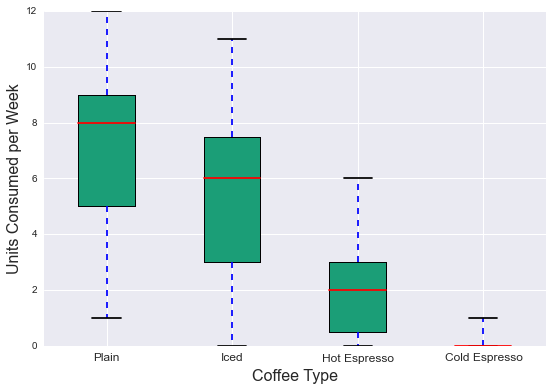

In [683]:
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
week_df = coffee.groupby('Week').sum().reset_index()
bp = ax.boxplot([week_df['Plain'],week_df['Iced'],week_df['Hot_espresso'],week_df['Cold_espresso']], patch_artist=True)
xtickNames = plt.setp(ax, xticklabels=['Plain', 'Iced', 'Hot Espresso', 'Cold Espresso'])
plt.setp(xtickNames, fontsize=12)
ax.set_ylabel('Units Consumed per Week', fontsize=16)
ax.set_xlabel('Coffee Type', fontsize=16)
[i.set(facecolor = '#1b9e77') for i in bp['boxes']];

** Cumulative Caffeine Intake by Category from 7/13 to 12/16 (156 Days) **

In [684]:
print '\n' + 'Sums from 7/13 to 12/16:' + '\n'
print coffee[['Plain', 'Iced', 'Hot_espresso', 'Cold_espresso', 'Units_caffeine']].sum()


Sums from 7/13 to 12/16:

Plain             165
Iced              125
Hot_espresso       43
Cold_espresso       5
Units_caffeine    402
dtype: int64


In [685]:
avg_caffeine_per_day = np.mean(coffee.groupby('Date').sum()['Units_caffeine'])
print "Consumed " + str(avg_caffeine_per_day) + " units of caffeine per day on average."

Consumed 2.66225165563 units of caffeine per day on average.


In [686]:
"""
Next I want to see if coffee impacts my mood at all. Here I run a t-test to test whether the difference between
the columns for pre and post-coffee mood are statistically different from zero. A t-stat higher than 1.96 makes 
the findings statistically significant by most standards. Here, my t-stat is significantly larger than 1.96 in 
magnitude at a value of -4.82, making the mood change statistically significant at the 99.99% confidence level.

For the visual thinkers, I show box plots of these two columns as well. Their medians are the same (5, an "average"
mood), but the after column is skewed noticably more positively than the before column.
"""

'\nNext I want to see if coffee impacts my mood at all. Here I run a t-test to test whether the difference between\nthe columns for pre and post-coffee mood are statistically different from zero. A t-stat higher than 1.96 makes \nthe findings statistically significant by most standards. Here, my t-stat is significantly larger than 1.96 in \nmagnitude at a value of -4.82, making the mood change statistically significant at the 99.99% confidence level.\n\nFor the visual thinkers, I show box plots of these two columns as well. Their medians are the same (5, an "average"\nmood), but the after column is skewed noticably more positively than the before column.\n'

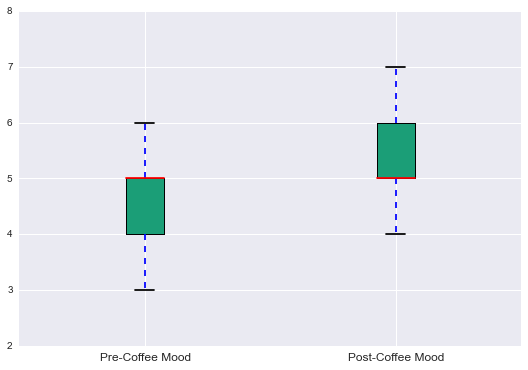

In [687]:
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot([coffee['Pre_mood'],coffee['Post_mood']], patch_artist=True)
xtickNames = plt.setp(ax, xticklabels=['Pre-Coffee Mood', 'Post-Coffee Mood'])
plt.setp(xtickNames, fontsize=12)
[i.set(facecolor = '#1b9e77') for i in bp['boxes']];
plt.show()
t_val = scipy.stats.ttest_ind(coffee['Pre_mood'],coffee['Post_mood'])

In [688]:
print "T-value: " + str(t_val[0])
print "P-value: " + str(t_val[1])
print "\nmood improved by an average of " + str(np.mean(coffee['Mood_change'])) + " points after drinking coffee"\
", which was highly\nstatistically significant"

T-value: -4.82093137374
P-value: 1.76728456723e-06

mood improved by an average of 0.360946745562 points after drinking coffee, which was highly
statistically significant


### Time to First Coffee

**For this next step** I create a new data frame that contains only the first row for each day. This is required to analyze how long I take between waking up and having my first coffee each day. I exclude rows where the time is earlier than 3am, since these late night coffees rather than early-morning ones. 

Over the 156 day period for which I have data, I spent a total of 44 days and 15 hours asleep, getting roughly 7 hours of sleep per night. I spent just under an hour and 45 minutes between waking up and drinking my first daily coffee on average. 

In [689]:
temp_df = coffee[coffee['Hour']>2].groupby('Date').first()
temp_df['Time_to_first_coffee'] = temp_df['Datetime'] - temp_df['Wake_time']  
print "Total time spent sleeping: " + str(np.sum(temp_df[['Hours_sleep']]['Hours_sleep']))
print "Average sleep per night: " + str(np.mean(temp_df[['Hours_sleep']]['Hours_sleep']))
print "Average time between waking up and drinking coffee: " + str(np.mean(temp_df[['Time_to_first_coffee']]['Time_to_first_coffee']))

Total time spent sleeping: 44 days 15:15:00
Average sleep per night: 0 days 07:08:30
Average time between waking up and drinking coffee: 0 days 01:39:26.400000


###Viewing how my time to first coffee has changed over time, we see that I go longer between waking up and drinking coffee at work than I do in school. 
This can be seen in the __drop occuring around September__, when I left work and began classes. This makes sense, since I have a coffee machine in my room, but had to wait until  I arrived at work to drink coffee during the summer. 

Mean time to coffee while working: 0 days 01:59:40.851063
Mean time to coffee while in school: 0 days 01:30:12.233009

Median time to coffee while working: 0 days 01:40:00
Median time to coffee while in school: 0 days 01:00:00


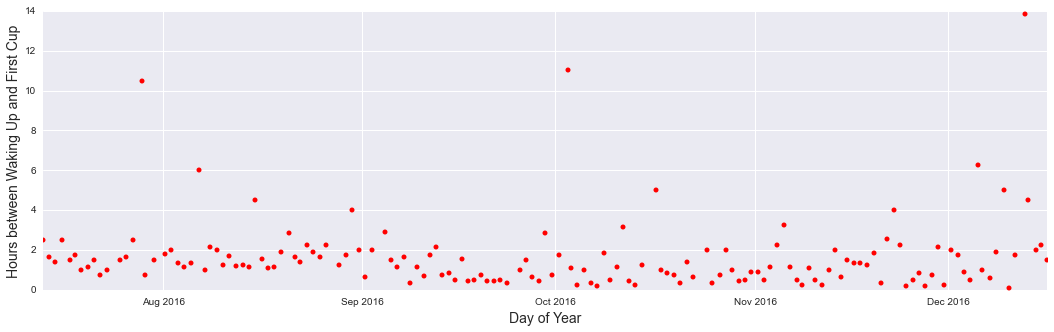

In [690]:
#label these axes

#use pre and post work dataframes to get mean during each of these periods. 
work_ttc = np.mean(temp_df[temp_df['Month']<9]['Time_to_first_coffee'])
work_ttc2 = np.median(temp_df[temp_df['Month']<9]['Time_to_first_coffee'])
school_ttc = np.mean(temp_df[temp_df['Month']>=9]['Time_to_first_coffee'])
school_ttc2 = np.median(temp_df[temp_df['Month']>=9]['Time_to_first_coffee'])
temp_df['Time_to_first_coffee'] = temp_df['Time_to_first_coffee']/ np.timedelta64(1, 'h') #conver to num. hours
fig = plt.figure(figsize=(18,5))
plt.plot_date(x=temp_df['Datetime'], y=temp_df['Time_to_first_coffee'], markersize=5, color='Red');
plt.xlabel('Day of Year', fontsize=14);
plt.ylabel('Hours between Waking Up and First Cup', fontsize=14);

print "Mean time to coffee while working: " + str(work_ttc)
print "Mean time to coffee while in school: " + str(school_ttc)
print "\nMedian time to coffee while working: " + str(pd.to_timedelta(work_ttc2))
print "Median time to coffee while in school: " + str(pd.to_timedelta(school_ttc2))

##Correlation Matrix
I tend to be in a better mood when I drink iced coffee than plain. This could be because I enjoy it more, but it could also be because it tends to be available to me in times and places where I am less overworked. Most of my late-night work sessions are fueled by plain coffee, for example, which can be seen in the positive correlation of plain coffee with stress, and the negative correlation between plain coffee and my mood. Iced coffee is typically only available to me in the mornings and afternoons, far-removed from any pre-deadline panic. 


**A few other things coming from this chart:**
* I got more sleep as the year went on (positive correlation between week, month, and hours slept)
* I drink less coffee when well-rested
* I became more stressed as the year went on (i.e. as midterms and finals week approached)
* I drink more coffee when I'm stressed

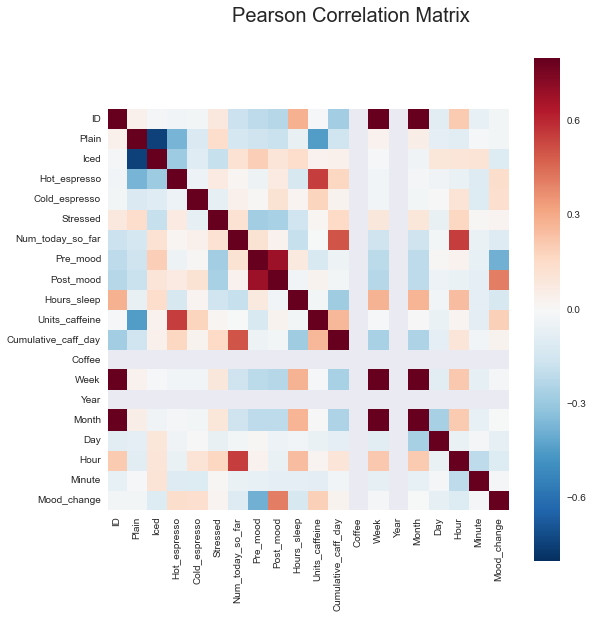

In [691]:
coffee['Hours_sleep'] = coffee['Hours_sleep']/ np.timedelta64(1, 'h')
corrmat = coffee.corr()
fig, ax = plt.subplots(figsize=(9,9)) 
plt.suptitle('Pearson Correlation Matrix', fontsize=20)
sns.heatmap(corrmat, vmax=.8, square=True);

# Trend Analysis
What are my habits? How have they changed over time? What type of schedule do I follow?

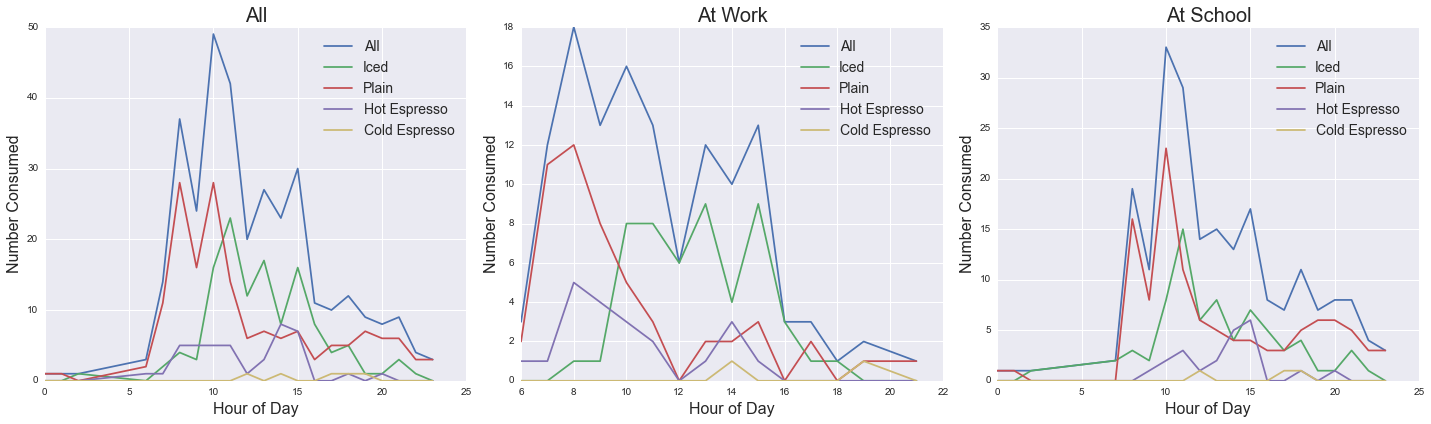

In [692]:
# pattern by hour of day. All vs. each individual class of coffee. (like in the spreadsheet)
# make this three plots inline. All vs work vs school

def plot(ax, hour_df, title):
    ax.plot(hour_df['Hour'],hour_df['Coffee'], label='All')
    ax.plot(hour_df['Hour'],hour_df['Iced'], label="Iced")
    ax.plot(hour_df['Hour'],hour_df['Plain'], label='Plain')
    ax.plot(hour_df['Hour'],hour_df['Hot_espresso'], label='Hot Espresso')
    ax.plot(hour_df['Hour'],hour_df['Cold_espresso'], label="Cold Espresso")
    ax.legend(fontsize=14)
    ax.set_xlabel('Hour of Day', fontsize=16)
    ax.set_ylabel('Number Consumed', fontsize=16)
    ax.set_title(title, fontsize=20)

dfs = [coffee.groupby('Hour').sum().reset_index(), \
       coffee[coffee['Month']<9].groupby('Hour').sum().reset_index(),\
       coffee[coffee['Month']>=9].groupby('Hour').sum().reset_index()]

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20,6))
plot(ax1, dfs[0], "All")
plot(ax2, dfs[1], "At Work")
plot(ax3, dfs[2], "At School")
plt.tight_layout()

## Time Series
A few events show up when plotting each category of coffee's consumption from the beginning of this experiment to its end. **Around week 43** you can see a noticable spike in iced coffee consumption; this is around when I purchased my cold brew machine. Later, in **week 50**, you can see a spike in plain coffee; this is when I installed a Keurig in the lab where I do the majority of my school work.  

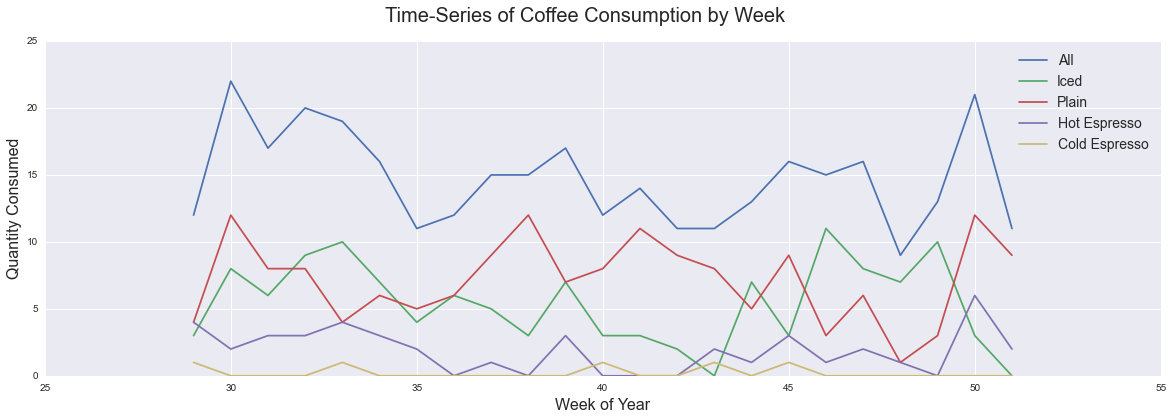

In [693]:
#again, I need to label these axes

#notice where I bought my cold brew device (iced shoots up) and where I installed the CS lab keurig (plain shoots back up)

# collapse by week and show a running time series of each category (ie if the ratio changed in an intersting way)
plt.figure(figsize=(20,6));
plt.plot(week_df['Week'],week_df['Coffee'], label='All')
plt.plot(week_df['Week'],week_df['Iced'], label="Iced")
plt.plot(week_df['Week'],week_df['Plain'], label='Plain')
plt.plot(week_df['Week'],week_df['Hot_espresso'], label='Hot Espresso')
plt.plot(week_df['Week'],week_df['Cold_espresso'], label="Cold Espresso")
plt.suptitle('Time-Series of Coffee Consumption by Week', fontsize=20)
plt.xlabel('Week of Year', fontsize=16);
plt.ylabel('Quantity Consumed', fontsize=16);
plt.legend(fontsize=14);

In [694]:
"""
label the below bar charts and make them all go in one line. 

not necessary to give each one its own line. 

perhaps add trendlines to these


discuss what they mean

"""

'\nlabel the below bar charts and make them all go in one line. \n\nnot necessary to give each one its own line. \n\nperhaps add trendlines to these\n\n\ndiscuss what they mean\n\n'

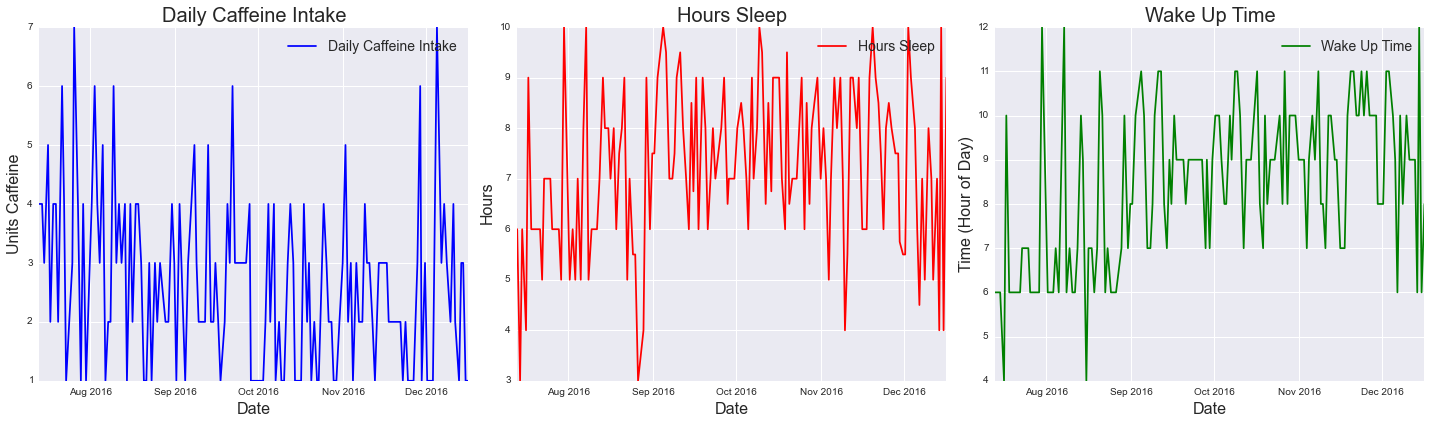

In [695]:
maxes = coffee.groupby('Date').last()
maxes['Wake_hour'] = maxes['Wake_time'].dt.hour

def plot(ax, var, label, ylab, color):
    ax.plot(maxes['Datetime'],maxes[var], label=label, color=color)
    ax.legend(fontsize=14)
    ax.set_xlabel('Date', fontsize=16)
    ax.set_ylabel(ylab, fontsize=16)
    ax.set_title(label, fontsize=20)


fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20,6))
plot(ax1, 'Cumulative_caff_day', "Daily Caffeine Intake", 'Units Caffeine', 'blue')
plot(ax2, 'Hours_sleep', "Hours Sleep", 'Hours', 'red')
plot(ax3, 'Wake_hour', 'Wake Up Time', 'Time (Hour of Day)', 'green')

plt.tight_layout()

In [696]:
"""
a quick summary cell in markdown. bi-modal because of differing T/Th vs M/W/F class schedules.
"""

'\na quick summary cell in markdown. bi-modal because of differing T/Th vs M/W/F class schedules.\n'

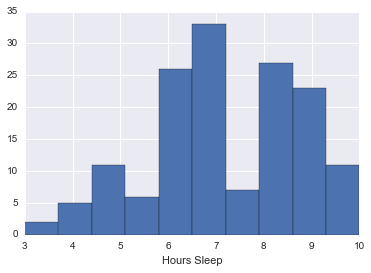

In [697]:
#these are significantly different which is interesting

maxes['Hours_sleep'].hist().set_xlabel('Hours Sleep');


In [698]:
"""
#more of a weekend worker at school. a more steady consumer at work. fridays basically the same as saturdays in school.

again, give a quick interpretation of these
"""

'\n#more of a weekend worker at school. a more steady consumer at work. fridays basically the same as saturdays in school.\n\nagain, give a quick interpretation of these\n'

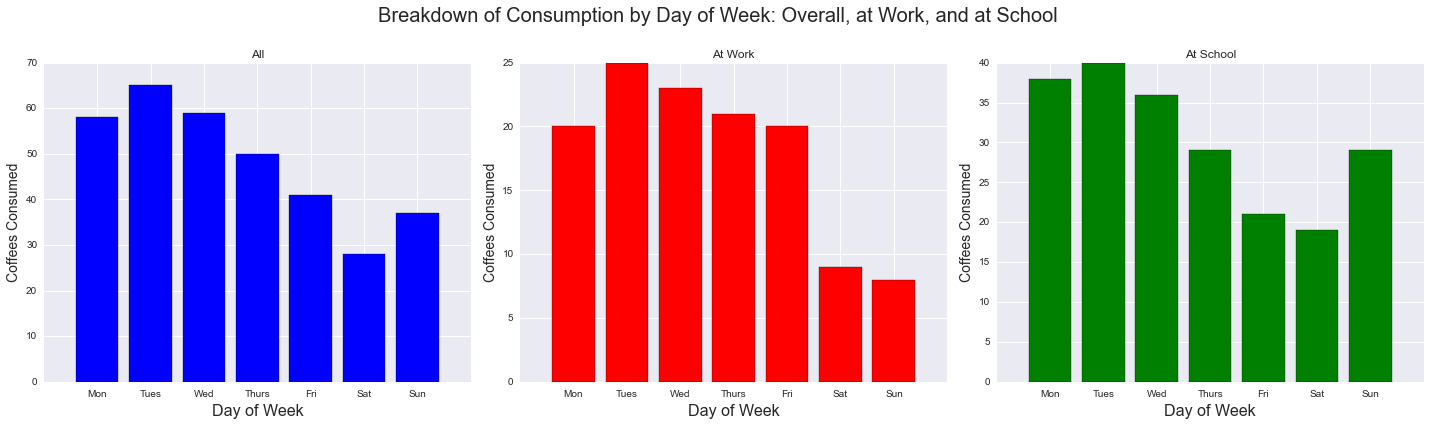

In [699]:
#more of a weekend worker at school. a more steady consumer at work. fridays basically the same as saturdays in school.

coffee['DOW_numerical'] = coffee['Datetime'].dt.dayofweek

def plot(ax, df, title, color):
    ax.bar([0,1,2,3,4,5,6], df.groupby('DOW_numerical').count().reset_index()['Coffee'],align='center', color=color)
    ax.set_xlim([-1, 6])
    #ax.set_xticks([0,1,2,3,4,5,6,7], ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
    ax.set_xlabel('Day of Week', fontsize=16)
    ax.set_ylabel('Coffees Consumed', fontsize=14)
    ax.set_title(title)

dfs = [coffee, coffee[coffee['Month']<9],coffee[coffee['Month']>=9]]

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20,6))
fig.suptitle("Breakdown of Consumption by Day of Week: Overall, at Work, and at School", fontsize=20)
plot(ax1, dfs[0], "All", 'blue')
plot(ax2, dfs[1], "At Work", 'red')
plot(ax3, dfs[2], "At School", 'green')
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.setp((ax1, ax2, ax3), xticks=[0,1,2,3,4,5,6,7], xticklabels=['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']);